# Catégorisez automatiquement des questions
## Analyse exploratoire des données (Stack Overflow)
### OpenClassRooms

**réalisation** : Fabrice Deprez
**date**        : 05/20223

a partir de l'API Stack Overflow, nous allons récupérer un ensemble de données que nous allons étudier
[Data](https://data.stackexchange.com/stackoverflow/query/new)

la requête doit avoir :

   * un nombre de vue 
   * des commentaires 
   * des réponses
   * des mise en favoris
   * un score significatif
   * au moins 5 tags

`SELECT TOP 500000 CreationDate, Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount
FROM Posts 
WHERE CreationDate, ViewCount > 10 
AND FavoriteCount > 10
AND Score > 5 AND 
AnswerCount > 0 
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5`

In [24]:
#!pip install matplotlib
!pip install pip install scikit-learn

#### Importations

In [25]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import datetime as dt
import scipy.stats as st
import missingno as msno
import warnings
#warnings.filterwarnings(action='ignore',category=FutureWarning)
# Désactiver tous les avertissements
warnings.filterwarnings("ignore")

import random
from IPython.display import Markdown, display

from nltk.tokenize import word_tokenize
os.environ['OMP_NUM_,nmTHREADS'] = '1'

import transformers
from transformers import BertTokenizer as BTokenizer
#from transformers import *
os.environ["TF_KERAS"]='1'


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#%pylab 
#%matplotlib inline
import seaborn as sns



import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re as regex  # Renommer la bibliothèque re

# Télécharger les ressources nécessaires pour NLTK
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaneda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaneda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
# -- cette fonction permet d'afficher du markdown dans la réponse de l'exécution d'un code
def markdown(string):
    display(Markdown(string))
    
# -- cette fonction permet d'afficher les informations complètes d'un dataframe
def show_informations(df, title):
    markdown(f'*** {title} ***')
    print("Total: {} enregistrements pour {} variables".format(df.shape[0],df.shape[1]))
    print(df.columns)
    print(df.info(verbose= True, show_counts=True))
    msno.bar(df)     
    
def visualize_continuous_variable(data, col, bins='sturges'):
    """
    Diagramme de distribution, diagramme en boîte et figures de distribution statistique
    
    Args: 
        data(DataFrame): Nom du dataframe 
        col(String): Nom de la colonne pour plot
        
    Returns:
        Graphiques et figures de distribution des variables
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(50,10))
    
    ax[0].hist(data[col], bins=bins, edgecolor='black')
    ax[0].set_xlabel(f"{col}")
    ax[0].set_ylabel("Nombre d'observations")
    ax[0].set_title(f"Histogramme de la variable {col}")
    
    sns.boxplot(data=data, x=col, ax=ax[1])
    ax[1].set_xlabel(f"{col}")
    ax[1].set_ylabel("Nombre d'observations")
    ax[1].set_title(f"Boîte à moustaches de la variable {col}")
    
    plt.show()
    
    print("\n" + "-" * 50 + "\n")
    print(f"Indicateurs statistiques de distribution de la variable {col}:")
    display(data[col].describe())
    
    
#def visualize_continuous_variable(data, col, bins='sturges'):
#    """
#    Diagramme de distribution, diagramme en boîte et figures de distribution statistique
    
#    Args: 
#        data(DataFrame): Nom du dataframe 
        
#        col(String): Nom de la colonne pour plot
        
#    Returns:
#        Graphiques et figures de distribution des variables
#    """
    
#    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(50,10))
    
#    sns.histplot(data=data, x=col, bins='sturges', kde=True, ax=ax[0])
#    ax[0].set_xlabel(f"{col}")
#    ax[0].set_ylabel("Nombre d'observations")
#    ax[0].set_title(f"Histograme de la variable {col}")
    
#    sns.boxplot(data=data, x=col)
#    ax[1].set_xlabel(f"{col}")
#    ax[1].set_ylabel("Nombre d'oservations")
#    ax[1].set_title(f"Boîte à moustaches de la variable {col}")
#    plt.show()
    
#    print("\n" + "-" * 50 + "\n")
#    print(f"Indicateurs statistiques de distribution de la variable {col}:")
#    display(data[col].describe())    
    
def plot_boxplot(data, col):
    """
    Affiche un diagramme en boîte (boxplot) pour une colonne spécifiée du DataFrame.
    
    Args:
        data (DataFrame): Le DataFrame contenant les données.
        col (str): Le nom de la colonne à représenter.
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, y=col)
    plt.title(f"Diagramme en boîte de la colonne {col}")
    plt.xlabel(col)
    plt.ylabel("Valeurs")
    plt.show()

    
def display_formatted_comments(data, col):
    """
    Affiche les commentaires formatés pour une meilleure lisibilité.
    
    Args:
        data (DataFrame): Le DataFrame contenant les données.
        col (str): Le nom de la colonne contenant les commentaires.
    """
    for comment in data[col]:
        display(Markdown(f"**Commentaire:**\n\n{comment}\n\n{'-' * 50}\n"))
    
    
def clean_text(text):
    # Supprimer les balises HTML
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Supprimer la ponctuation et les caractères spéciaux
    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    # Mettre en minuscule
    text = text.lower()

    # Remplacer les mots spécifiques
    text = re.sub(r'\bC\+\+\b', 'cplusplus', text)
    #attention a casesentivie
    text = re.sub(r'\b5G\b', 'fiveg', text, flags=re.IGNORECASE)
    text = re.sub(r'\b4G\b', 'fourg', text, flags=re.IGNORECASE)
    # Ajoutez d'autres remplacements si nécessaire pour les mots spécifiques

    # Supprimer les mots vides
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatisation
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Rejoindre les tokens en une chaîne de caractères
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [27]:
data = pd.read_csv(f'./data/QueryResults.csv', sep=',', low_memory=False, encoding='utf-8')

*** Resultats StackOverflow ***

Total: 50000 enregistrements pour 9 variables
Index(['CreationDate', 'Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount',
       'FavoriteCount', 'AnswerCount'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CreationDate   50000 non-null  object
 1   Title          50000 non-null  object
 2   Body           50000 non-null  object
 3   Tags           50000 non-null  object
 4   Id             50000 non-null  int64 
 5   Score          50000 non-null  int64 
 6   ViewCount      50000 non-null  int64 
 7   FavoriteCount  50000 non-null  int64 
 8   AnswerCount    50000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 3.4+ MB
None


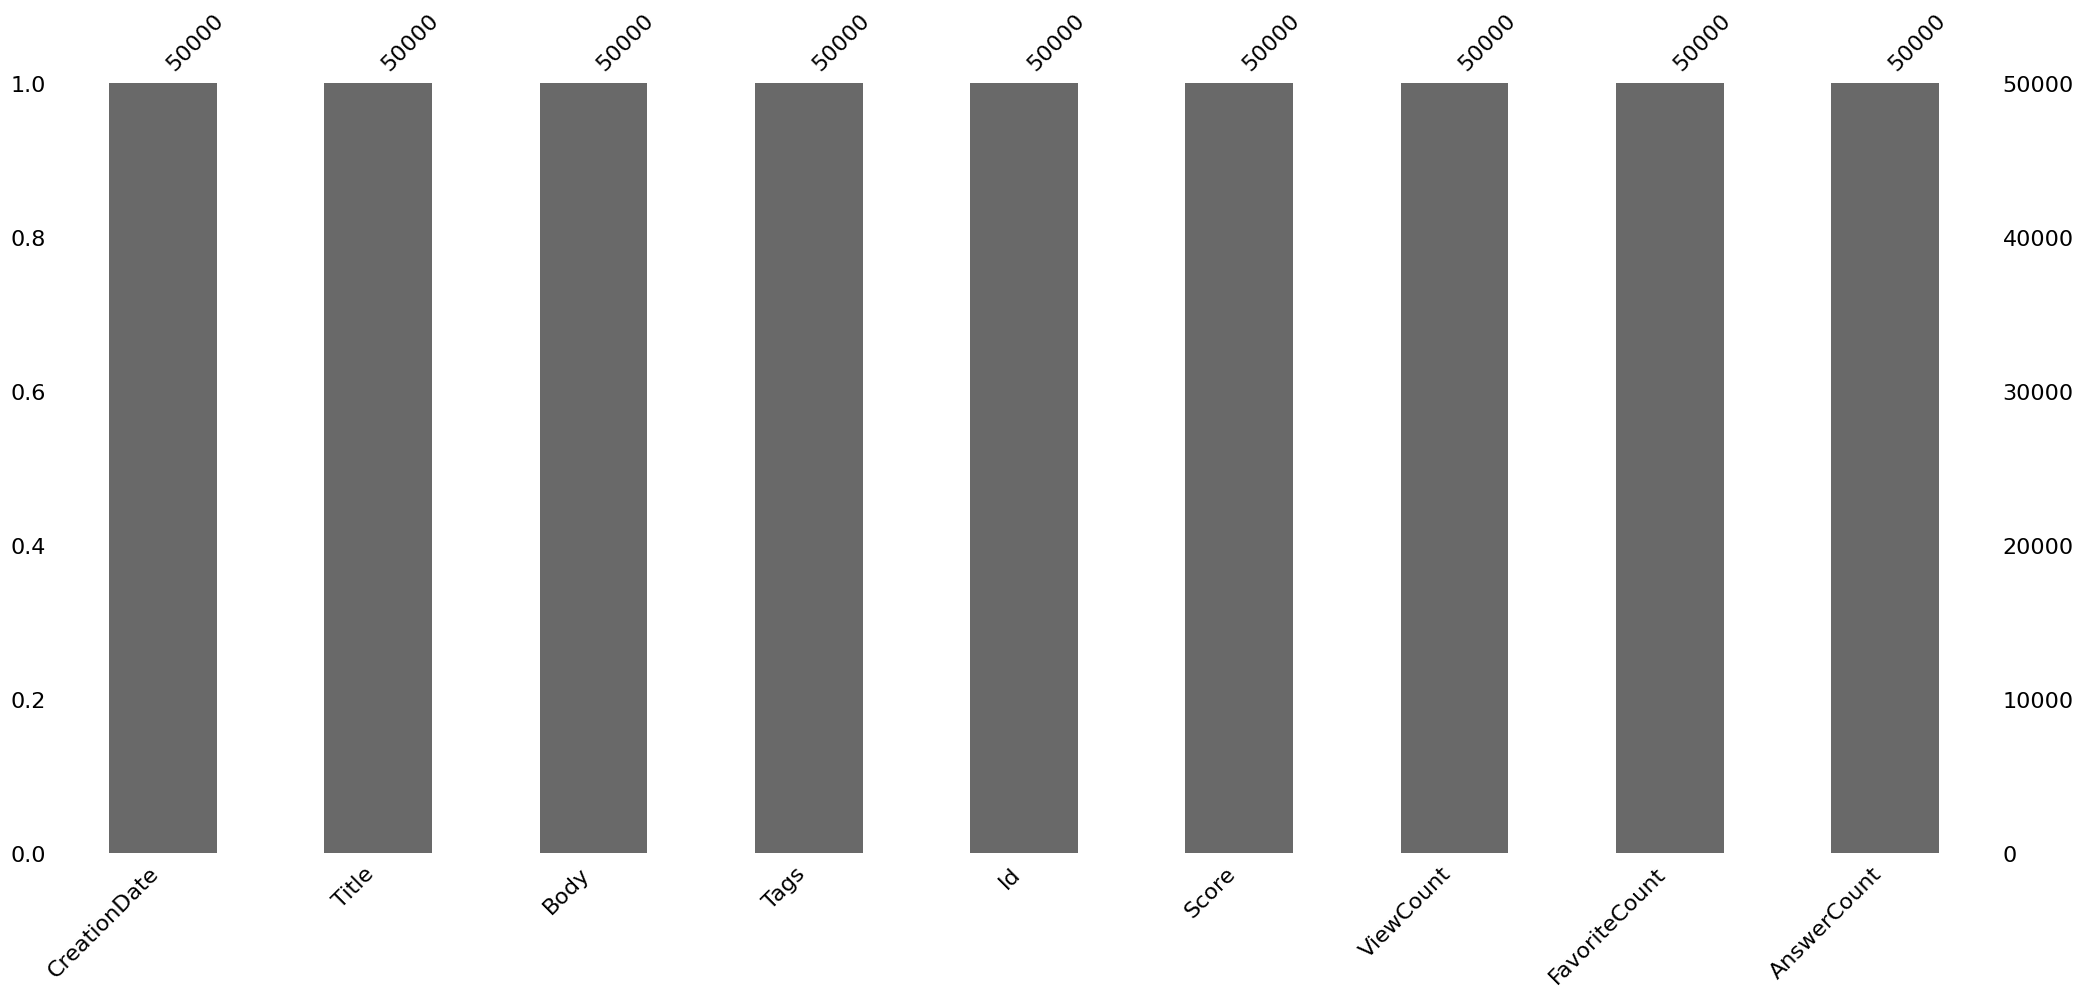

In [28]:
# -- On affiche ici les informations concernant CUSTOMERS
show_informations(data, 'Resultats StackOverflow')

In [29]:
data.sample(5, random_state=1)

,CreationDate,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
26247,2014-06-11 21:16:21,Google Analytics for iOS - Sending Custom Even...,<p>I decided to use Google Analytics over Flur...,<ios><objective-c><iphone><google-analytics><f...,24172712,11,7109,0,3
35067,2014-01-30 23:19:52,Spring Data Rest Pageable Child Collection,<p>I have an @Entity called User. It has a Set...,<spring><hibernate><spring-data><spring-data-j...,21469538,12,3948,0,1
34590,2019-10-19 12:14:11,How to right-align item labels in a custom Swi...,<p>I have the following Cocoa form:</p>\n\n<pr...,<forms><macos><cocoa><swiftui><appkit>,58463568,11,1911,0,2
16668,2014-09-10 12:48:51,How do I install dependencies when cross compi...,<p>I've successfully created a ghc cross compi...,<haskell><raspberry-pi><cross-compiling><ghc><...,25765893,15,1490,0,1
12196,2013-11-08 06:53:09,"Android4.4 can not handle sms intent with ""vnd...",<p>My application has a button to start defaul...,<java><android><android-intent><sms><android-4...,19853220,16,15043,0,4


In [30]:
#!pip install --upgrade pandas

### Analyse statistiques des variables numériques

il y a une baisse significative des posts après 2016, si on filtre par date, cela va pénaliser les publications les plus récentes, il faut prendre en compte ce point
qui ne doit pas être négligé. En effet, comme il y a une baisse de publications a partir de 2016, il faut vérifier que cela ne va pas pénaliser les posts les plus récents

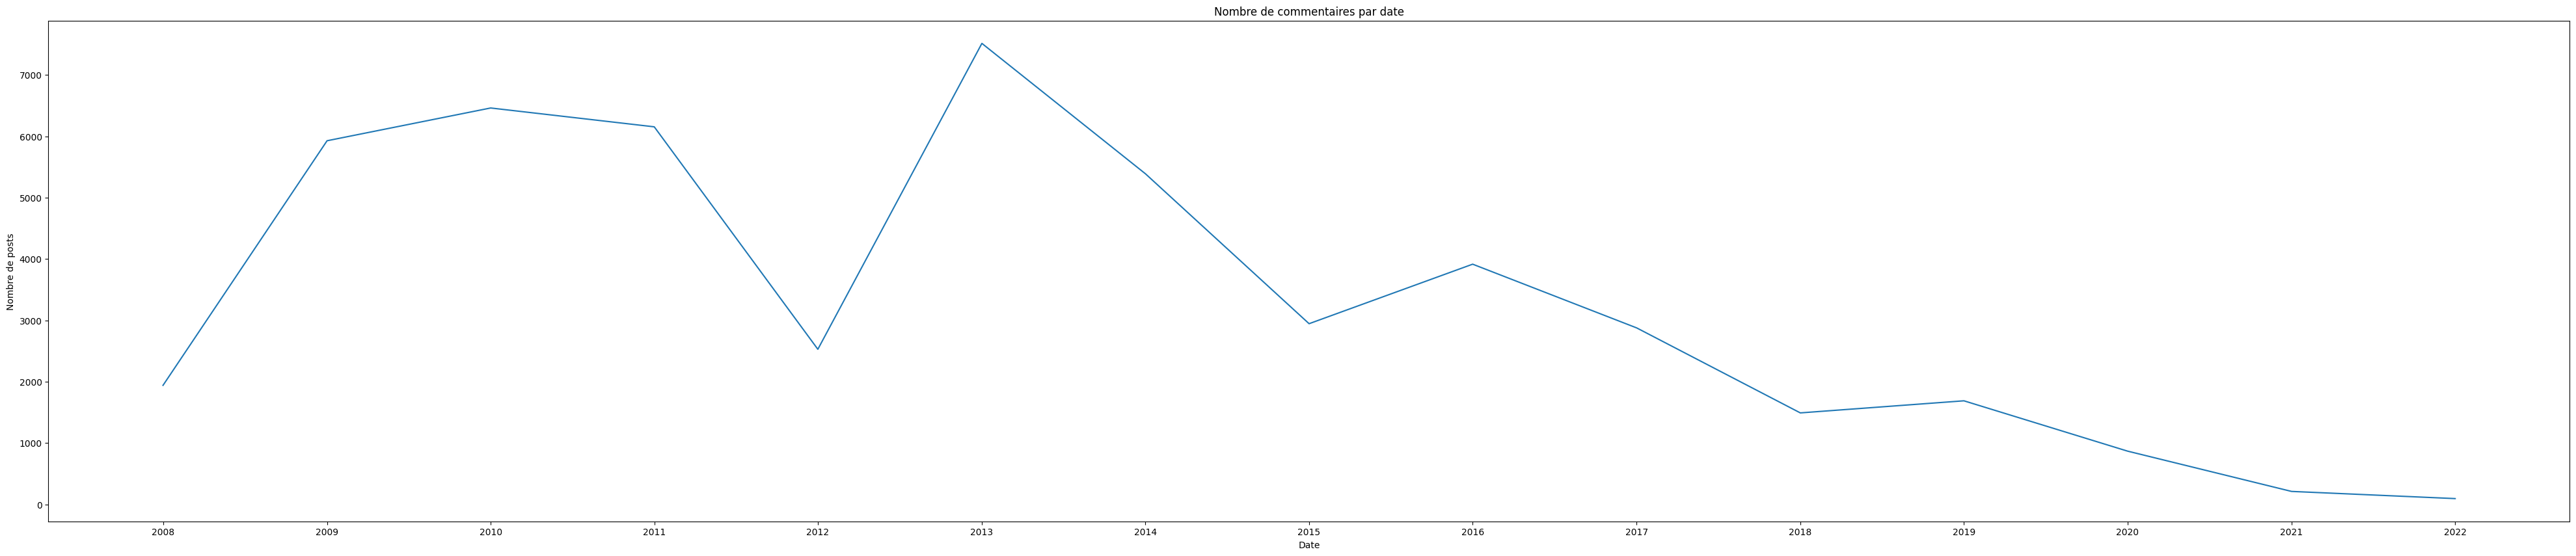

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(50, 10))
data['CreationDate'] = pd.to_datetime(data['CreationDate'])
CreationDateByDay = data['CreationDate'].dt.date.value_counts()

# Convertir les dates en objets datetime
dates = pd.to_datetime(CreationDateByDay.index)

# Calculer la somme des valeurs pour chaque année
values = CreationDateByDay.groupby(dates.year).sum()

# Création de l'abscisse avec une fréquence d'un an
years = pd.date_range(start=str(dates.min().year), end=str(dates.max().year), freq='YS')

# Tracer la courbe
ax.plot(years, values)

# Format de l'axe des dates
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_xlabel("Date")
ax.set_ylabel("Nombre de posts")
ax.set_title("Nombre de commentaires par date")

plt.show()

### visualisation des variables continues

### SCORE

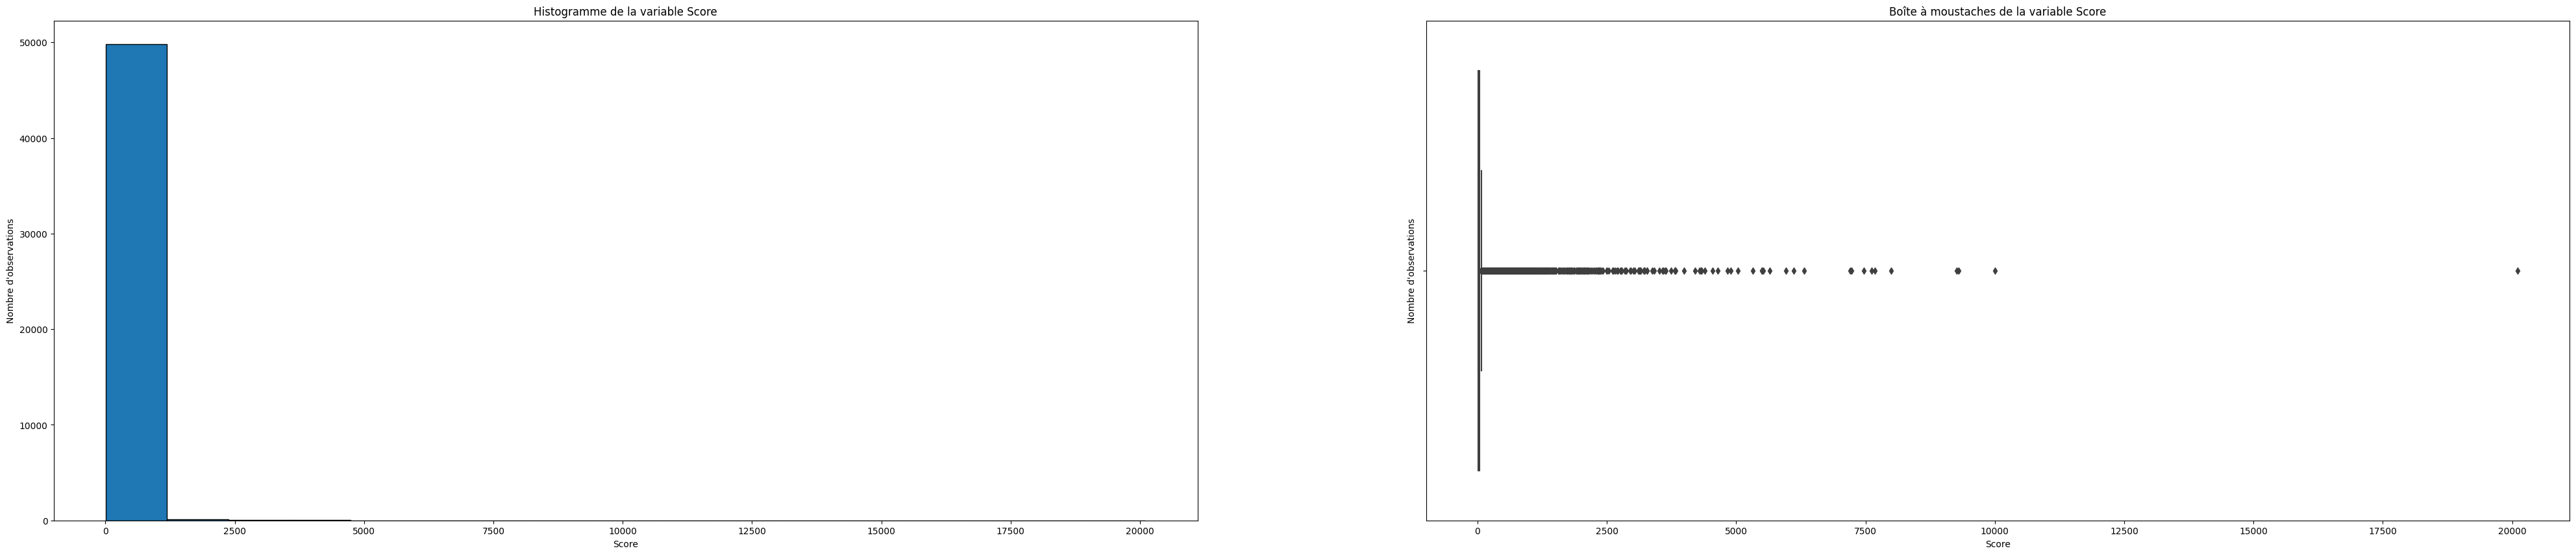


--------------------------------------------------

Indicateurs statistiques de distribution de la variable Score:


count    50000.000000
mean        56.268960
std        230.600982
min         11.000000
25%         14.000000
50%         20.000000
75%         39.000000
max      20107.000000
Name: Score, dtype: float64

In [32]:
visualize_continuous_variable(data=data, col='Score')

### ViewCount

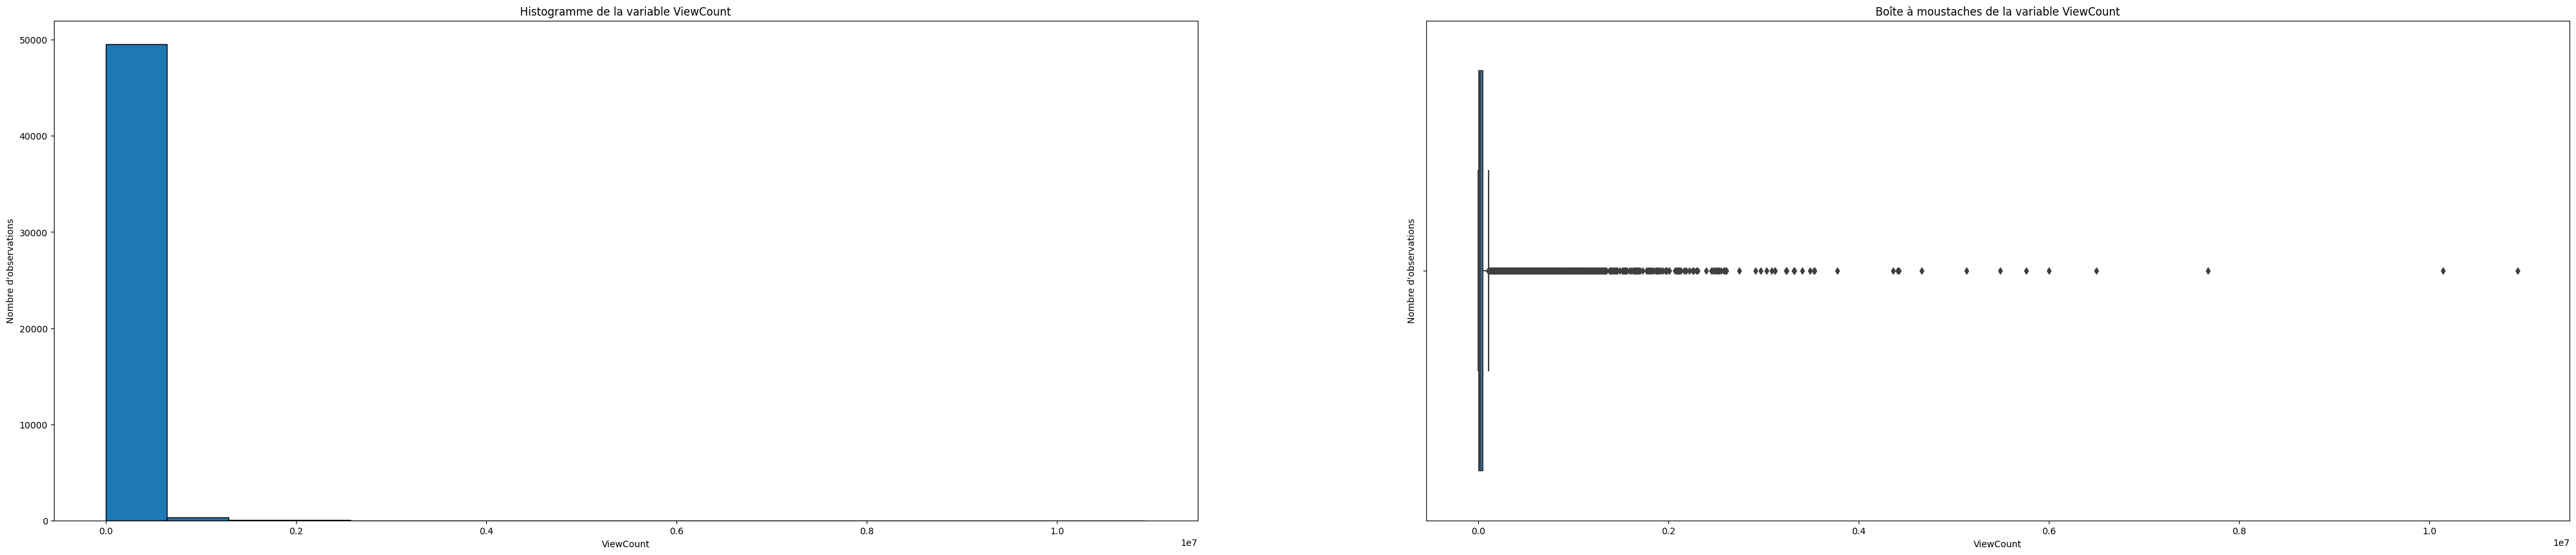


--------------------------------------------------

Indicateurs statistiques de distribution de la variable ViewCount:


count    5.000000e+04
mean     5.714557e+04
std      1.789337e+05
min      1.050000e+02
25%      8.250750e+03
50%      2.014750e+04
75%      4.836800e+04
max      1.092895e+07
Name: ViewCount, dtype: float64

In [33]:
visualize_continuous_variable(data=data, col='ViewCount')

### AnswerCount

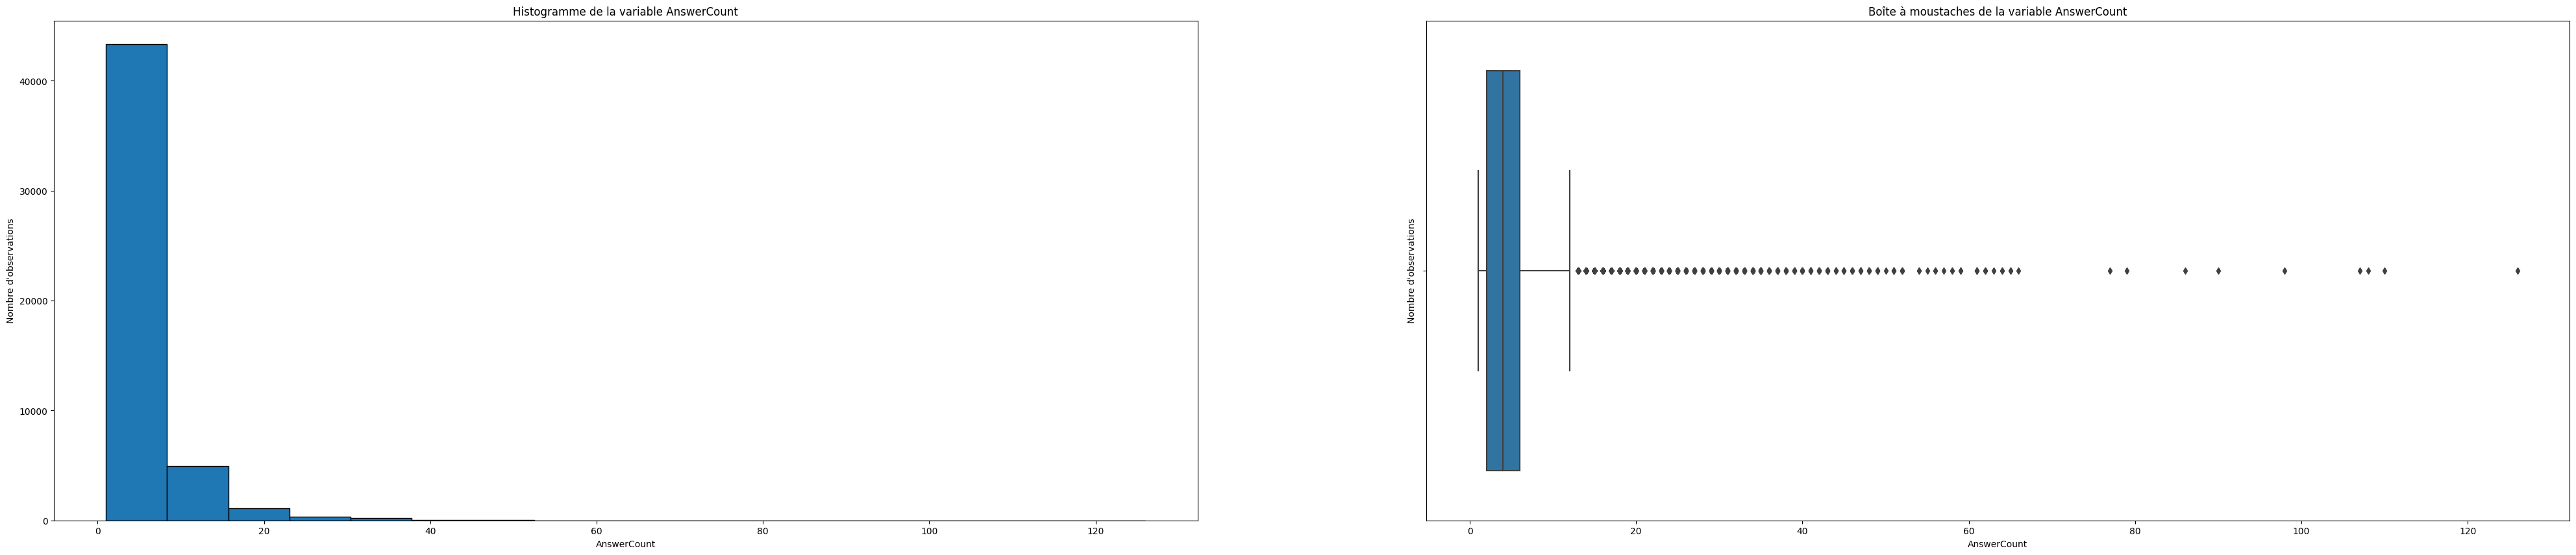


--------------------------------------------------

Indicateurs statistiques de distribution de la variable AnswerCount:


count    50000.000000
mean         5.023420
std          5.039684
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max        126.000000
Name: AnswerCount, dtype: float64

In [34]:
visualize_continuous_variable(data=data, col='AnswerCount')

### FavoriteCount

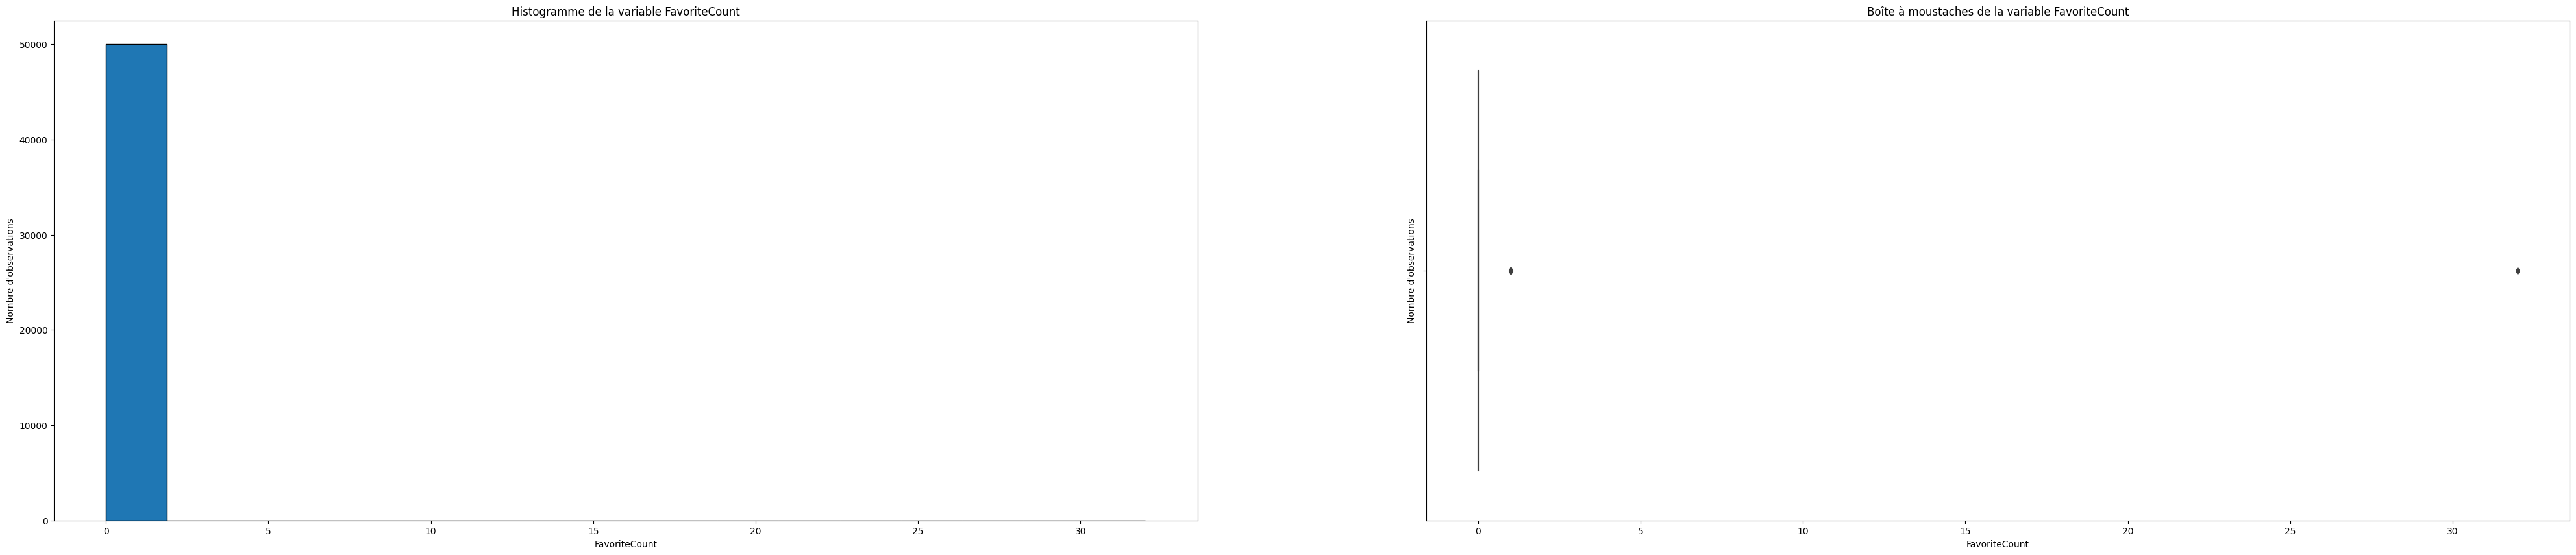


--------------------------------------------------

Indicateurs statistiques de distribution de la variable FavoriteCount:


count    50000.000000
mean         0.000760
std          0.143526
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         32.000000
Name: FavoriteCount, dtype: float64

In [35]:
# Supprimer les valeurs manquantes
#data = data.dropna(subset=['FavoriteCount'])

# Convertir la colonne en type numérique
#data['FavoriteCount'] = data['FavoriteCount'].astype(float)

# Gérer les valeurs aberrantes (par exemple, supprimer les valeurs supérieures à un certain seuil)
#threshold = 1000  # Définir le seuil des valeurs aberrantes
#data = data[data['FavoriteCount'] <= threshold]

visualize_continuous_variable(data=data, col='FavoriteCount')

In [36]:
# Calculer le nombre de valeurs supérieures à zéro dans la colonne 'FavoriteCount'
count_gt_zero = (data['FavoriteCount'] > 0).sum()

# Afficher le résultat
print("Nombre de valeurs supérieures à zéro : ", count_gt_zero)

Nombre de valeurs supérieures à zéro :  7


Pour en revenir a la vérification de la date de création par rapport au nombre de vue

on peut visualiser une possible corrélation en visualisant un nuage de point

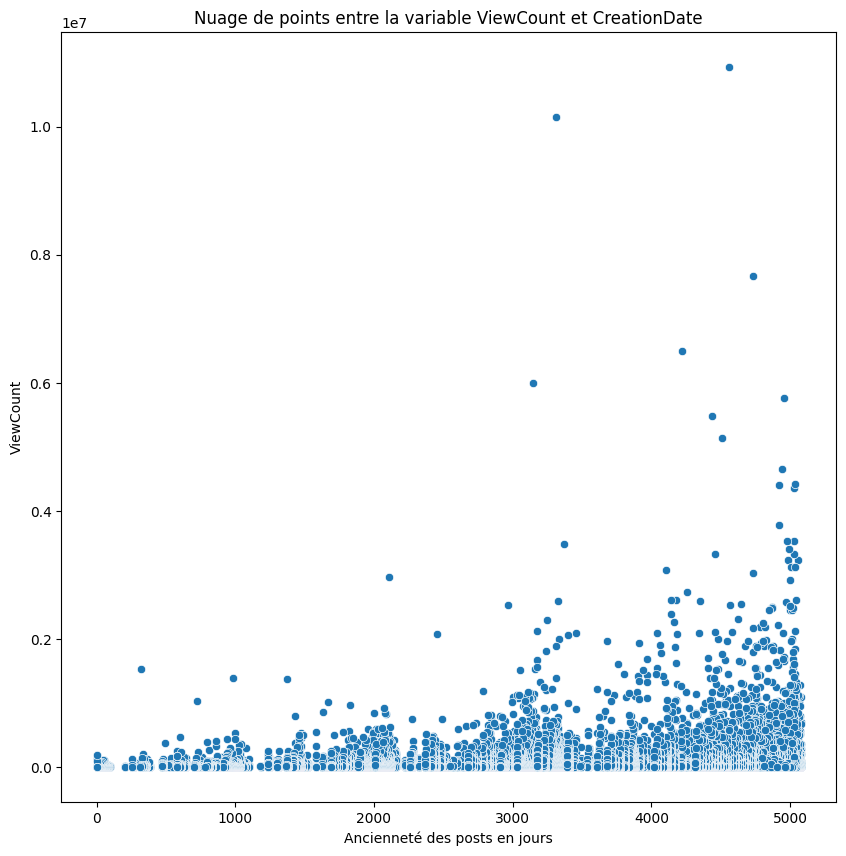

In [37]:
last_post = data["CreationDate"].max()
data["CreationDateTimeDelta"] = last_post - data["CreationDate"]
data["CreationDateTimeDelta"] = data["CreationDateTimeDelta"].dt.days

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
sns.scatterplot(data=data, x="CreationDateTimeDelta", y="ViewCount", ax=ax)
ax.set_xlabel("Ancienneté des posts en jours")
ax.set_label("Nombre de vues")
ax.set_title("Nuage de points entre la variable ViewCount et CreationDate")
plt.show()

In [84]:
# on constate clairement une corrélation entre le nombre de vue et l'ancienneté 
# pour s'en assurer on peut visualiser la matrice de correlation de spearman et Pearsno
# ajoutons une colonne pour avoir le nombre de vue par jour
data['ViewByDay'] =  data['ViewCount'] / (data['CreationDateTimeDelta']+0.000000001)

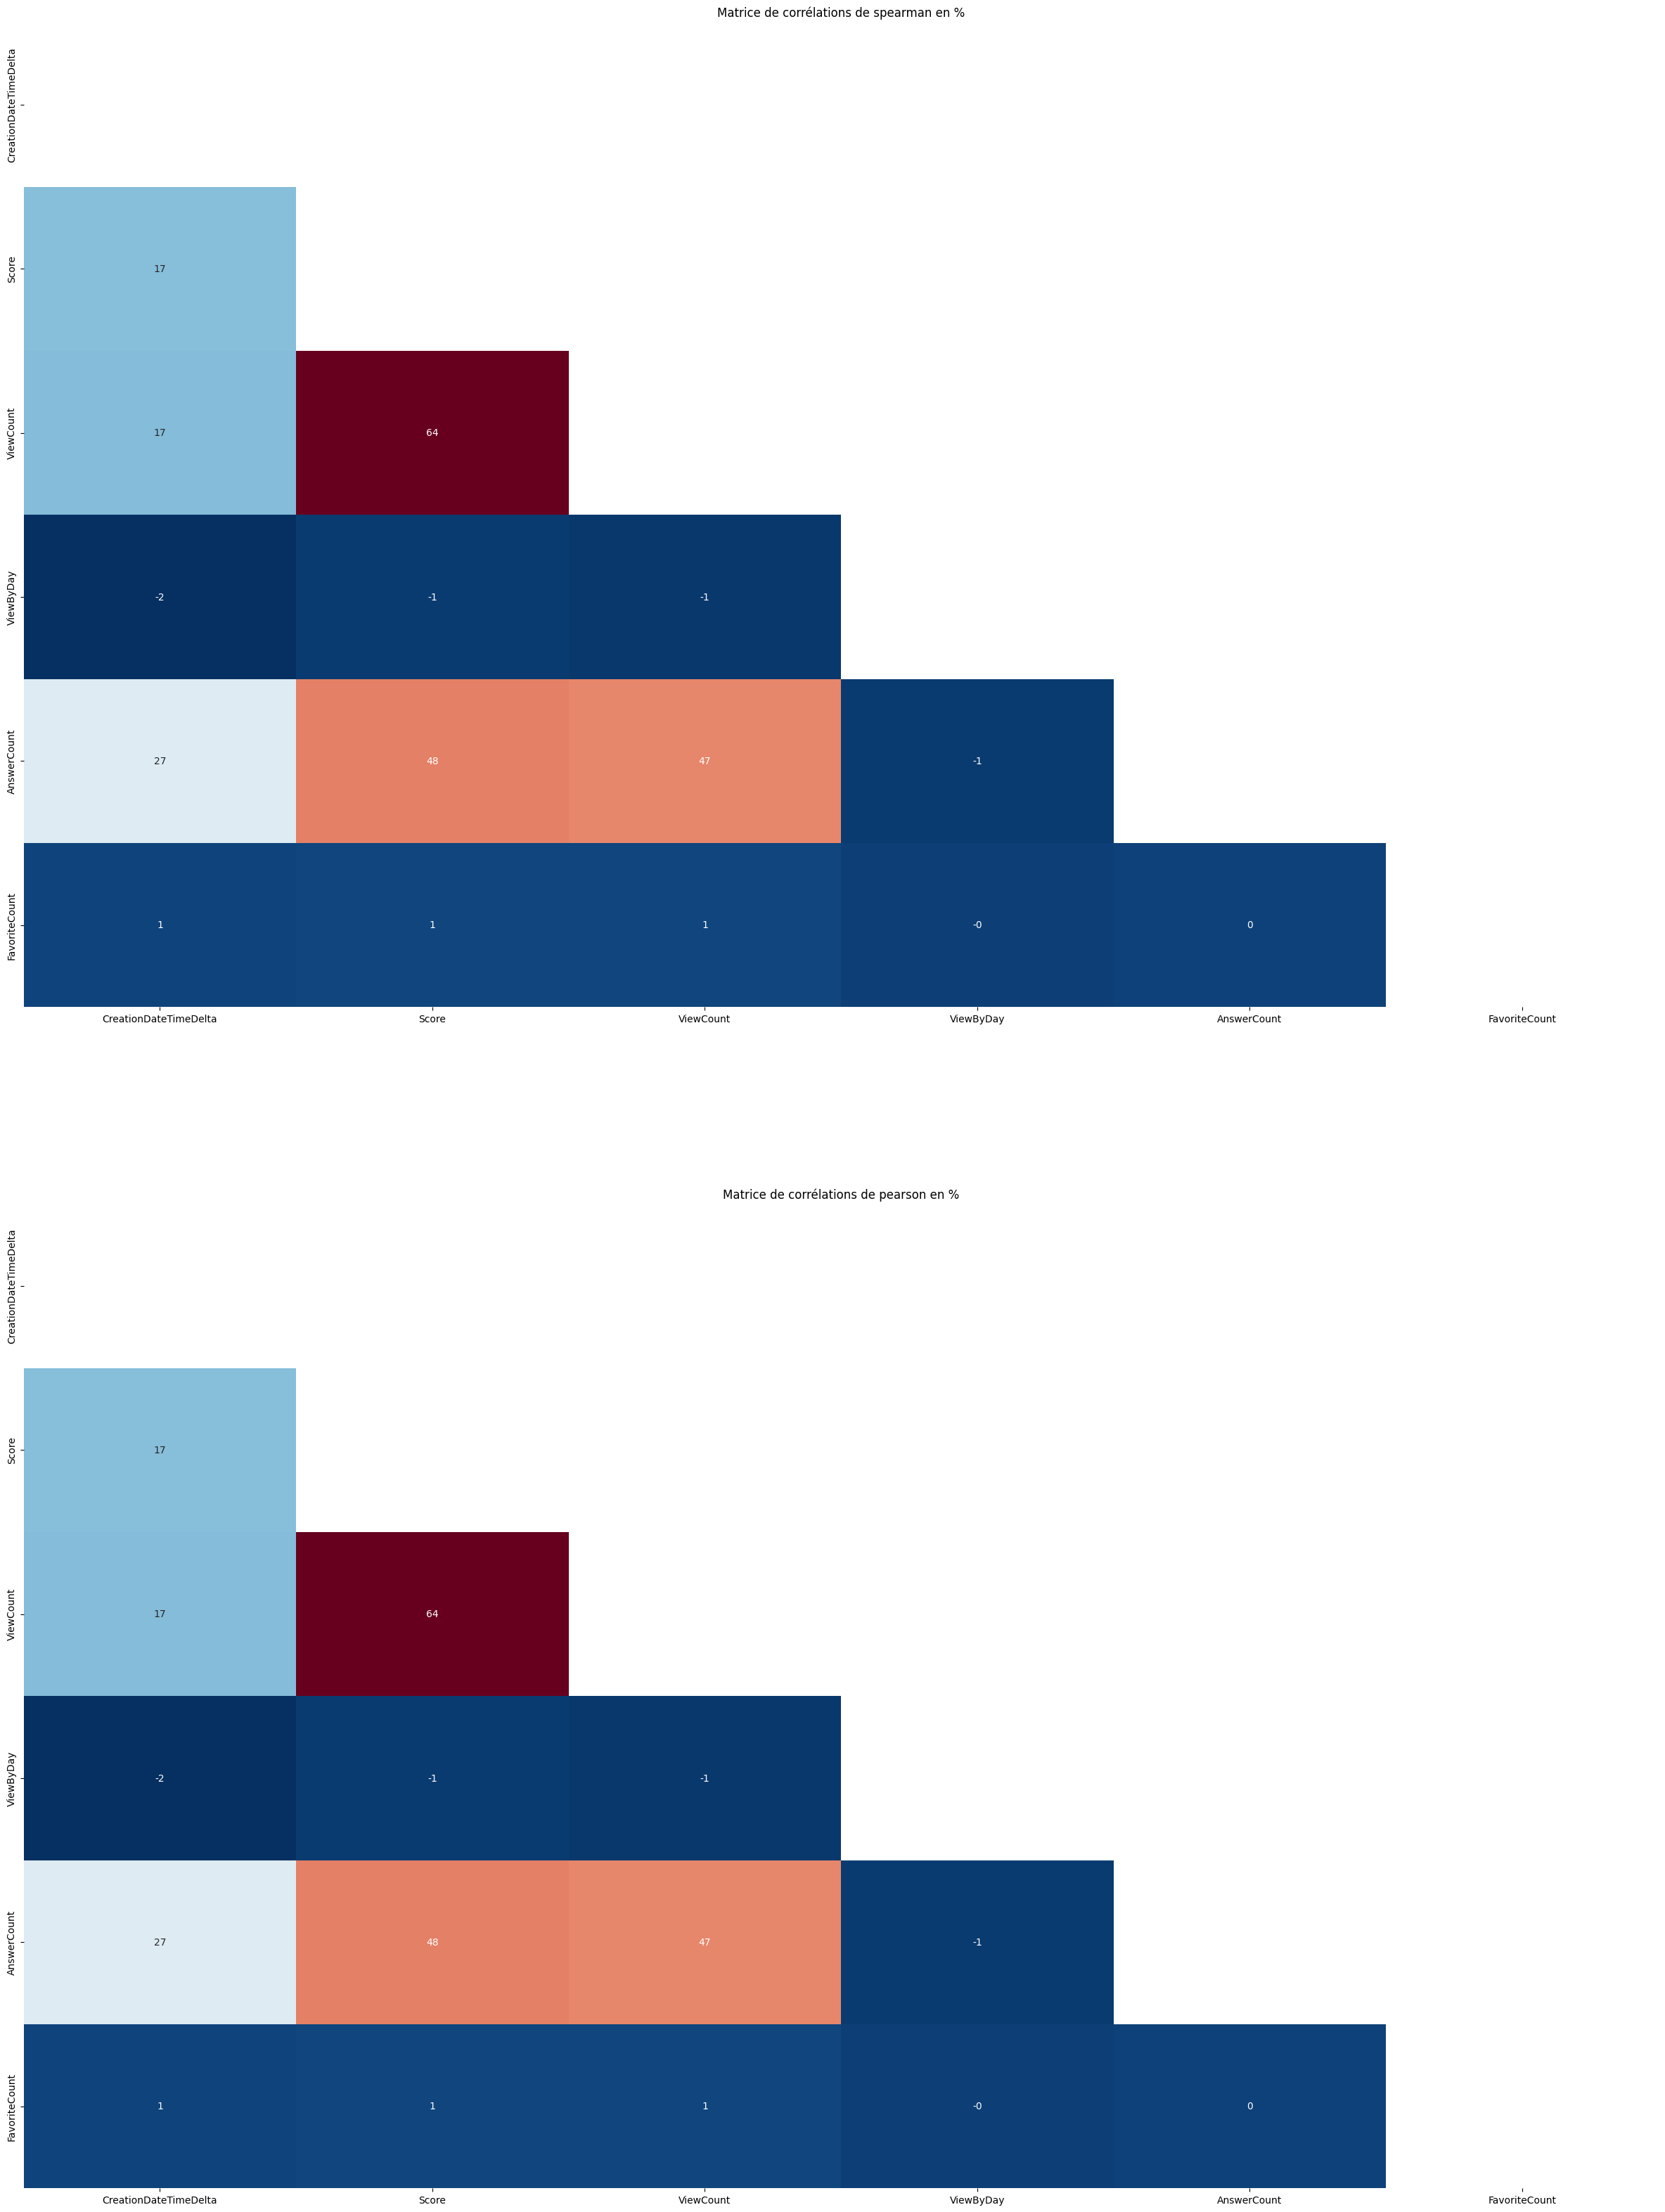

In [92]:
correlations = []
cleanning_masks = []

data_corr = data[["CreationDate","CreationDateTimeDelta","Score","ViewCount", "ViewByDay","AnswerCount","FavoriteCount"]]

methods = ["spearman", "pearson"]

for method in methods:
    correlation = data_corr.select_dtypes(include=['int64','float64']).corr(method="pearson") * 100
    cleanning_mask = np.zeros_like(correlation)
    upper_triangle = np.triu_indices_from(correlation)
    cleanning_mask[upper_triangle] = 1
    correlations.append(correlation)
    cleanning_masks.append(cleanning_mask)
        
fig, axes = plt.subplots(nrows=len(methods), figsize=(30,40))
fig.subplots_adjust(wspace=0.2)

for i in range(len(axes)):
    sns.heatmap(correlations[i], ax=axes[i], cmap="RdBu_r", mask = cleanning_masks[i], annot = True, fmt=".0f", cbar=False)

    axes[i].set_title(f"Matrice de corrélations de {methods[i]} en %")

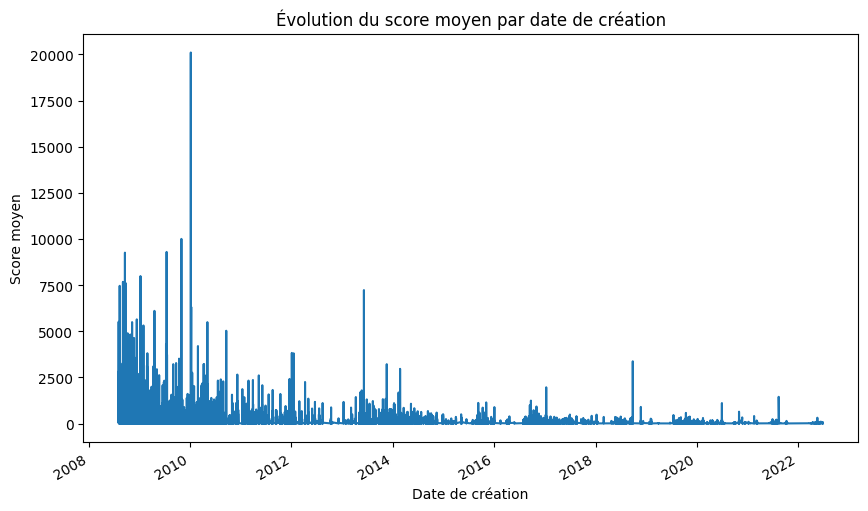

In [39]:
# Importer les bibliothèques nécessaires
import matplotlib.pyplot as plt
import seaborn as sns

# Effectuer un groupby sur la colonne 'CreationDate' et calculer la moyenne des scores pour chaque date
score_by_date = data.groupby('CreationDate')['Score'].mean()

# Créer le graphique linéaire
fig, ax = plt.subplots(figsize=(10, 6))
score_by_date.plot(ax=ax)
ax.set_xlabel("Date de création")
ax.set_ylabel("Score moyen")
ax.set_title("Évolution du score moyen par date de création")

# Afficher le graphique
plt.show()


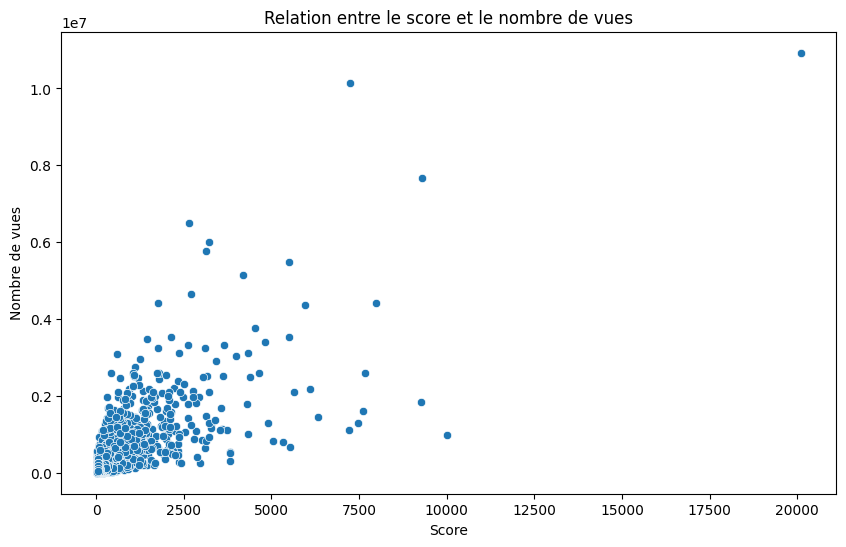

In [41]:
# graphique de dispersion
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Score', y='ViewCount')
plt.xlabel("Score")
plt.ylabel("Nombre de vues")
plt.title("Relation entre le score et le nombre de vues")

# Afficher le graphique
plt.show()

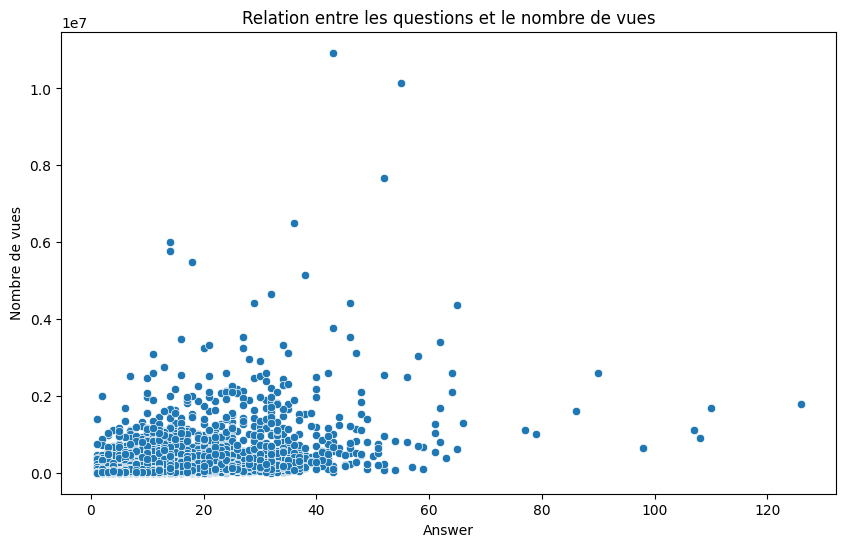

In [42]:
# graphique de dispersion
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='AnswerCount', y='ViewCount')
plt.xlabel("Answer")
plt.ylabel("Nombre de vues")
plt.title("Relation entre les questions et le nombre de vues")

# Afficher le graphique
plt.show()

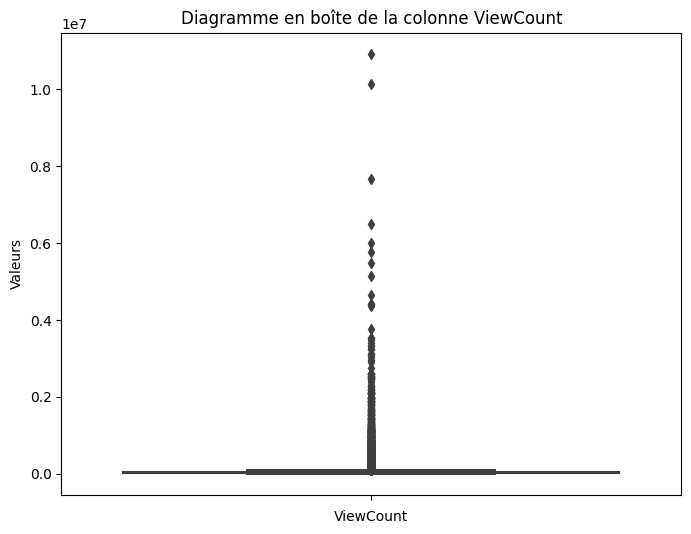

In [43]:
plot_boxplot(data, 'ViewCount')

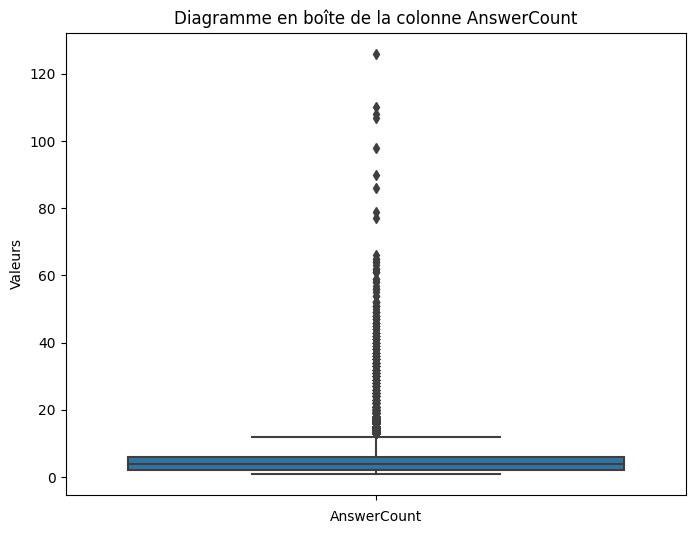

In [44]:
plot_boxplot(data, 'AnswerCount')

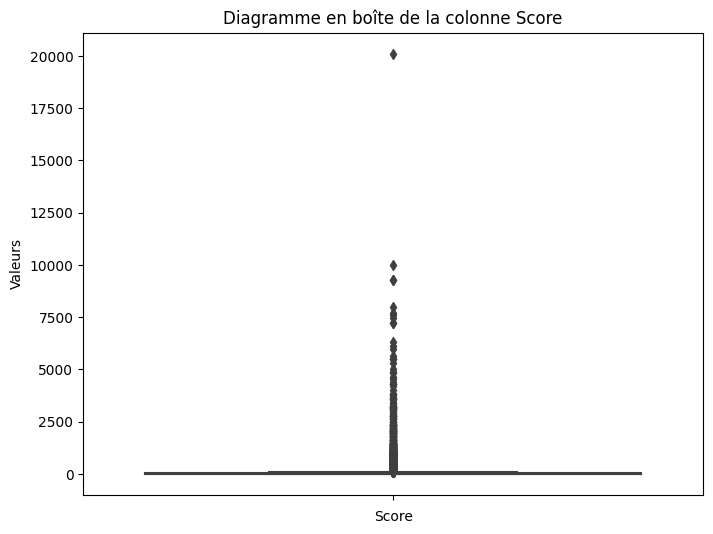

In [45]:
plot_boxplot(data, 'Score')

### Nettoyage

In [46]:
# application de la transformation logarithmique sur les colonnes ViewCount, AnswerCount et Score
data['ViewCount'] = np.log1p(data['ViewCount'])
data['AnswerCount'] = np.log1p(data['AnswerCount'])
data['Score'] = np.log1p(data['Score'])
# identification des seuils supérieurs pour chaque colonne (basé sur l'écart type)
viewcount_threshold = np.mean(data['ViewCount']) + 3 * np.std(data['ViewCount'])
answercount_threshold = np.mean(data['AnswerCount']) + 3 * np.std(data['AnswerCount'])
score_threshold = np.mean(data['Score']) + 3 * np.std(data['Score'])
# suppression des outliers
data = data[data['ViewCount'] <= viewcount_threshold]
data = data[data['AnswerCount'] <= answercount_threshold]
data = data[data['Score'] <= score_threshold]

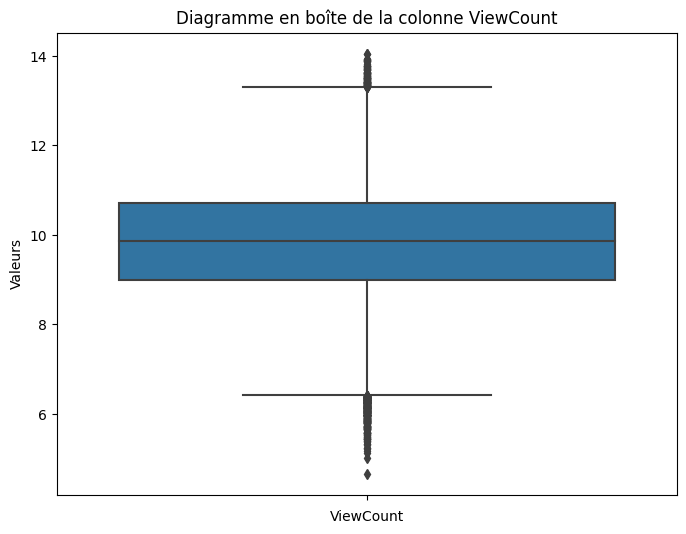

In [47]:
plot_boxplot(data, 'ViewCount')

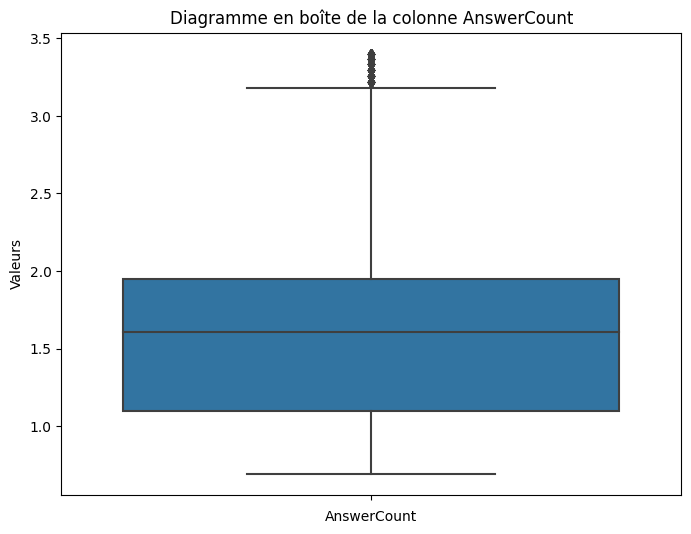

In [48]:
plot_boxplot(data, 'AnswerCount')

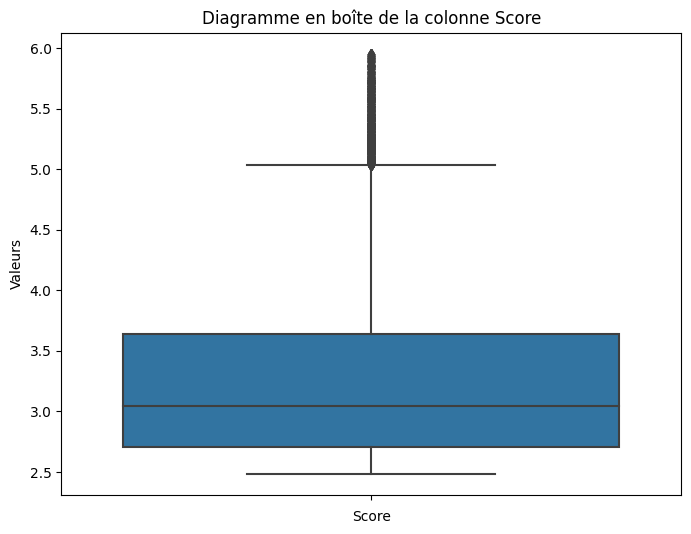

In [49]:
plot_boxplot(data, 'Score')

Affichon queques commentaires pour voir leur contenu

### sample_size = 5

random_sample = data.sample(n=sample_size)

display_formatted_comments(random_sample, 'Body')

sauvegardons les données pour passer a la modélisation

In [95]:
data.to_csv("./data/cleaned_data.csv")